# Cleaning - missing and duplicate data

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## Generate a t-shirt order<br>
have a name, a t-shirt size, a t-shirt color and a weight(in pounds)<br>
Uses the <a href="https://pypi.org/project/names/https://pypi.org/project/names/">names </a> module to generate random names

In [46]:
import utils as ut
df = ut.generate_tshirt_order()
df

,weight,t_shirt_size,t_shirt_color,name
0,88.284792,small,black,Roxanne Huey
1,119.165059,small,green,Douglas Nutt
2,91.200858,small,green,Todd Stuer
3,83.445859,small,red,Maria Hibler
4,87.290755,small,blue,David Huntsinger
...,...,...,...,...
295,175.323851,large,green,Clyde Corcoran
296,190.092514,large,orange,Latarsha Neal
297,192.956741,large,green,Adelina William
298,237.260993,large,blue,Cheryl Pennisi


### Make some duplicates

In [47]:
# make some duplicates just to show how to handle duplicates (delete them)
#lets find the oldest male and female
def fun1(df,numb=5):
    #generates numb rows from df
    return (df.iloc[0:numb,:])


#generates numb rows from each group to be used as duplicates
df_dups=df.groupby('t_shirt_size').apply(fun1, numb=5)
df_dups

weight t_shirt_size t_shirt_color              name
t_shirt_size                                                             
large        200  158.233361        large           red          Jan Tang
             201  160.472101        large        orange    Timothy Miller
             202  187.097422        large           red         Edna Turk
             203  174.399017        large          blue       Willie Hall
             204  149.789781        large           red       Kris Angelo
medium       100  149.247679       medium         green  Mildred Raterman
             101  130.399074       medium         black   Matthew Calzada
             102  138.196786       medium          blue        Mary Bowie
             103  130.652350       medium        orange  Ericka Rodriguez
             104  141.573538       medium          blue      Dennis Lopez
small        0     88.284792        small         black      Roxanne Huey
             1    119.165059        small         green      Douglas Nutt
             2     91.200858        small         green        Todd Stuer
             3     83.445859        small           red      Maria Hibler
             4     87.290755        small          blue  David Huntsinger

### Append to original dataframe

In [48]:
df=df.append(df_dups, ignore_index=True)
len(df)

315

In [49]:
df.name.duplicated().sum()

15

### randomly select 20% of rows for t_shirt_size ommision

In [50]:
#first save orig size for later comparison
df['t_shirt_size_orig'] = df['t_shirt_size']

In [51]:
import random
res = random.sample(range(0, len(df)), int(0.2 * len(df)))
print(f'Number of rows to have "t_shirt_size" set to np.Nan is {len(res)}' )
for loc in res:
    df.loc[loc,'t_shirt_size'] = np.NaN

Number of rows to have "t_shirt_size" set to np.Nan is 63


In [52]:
#how many are null?
df.t_shirt_size.isna().sum()

63

In [54]:
#show the missing data
df[df.t_shirt_size.isna()]

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
2,91.200858,NaN,green,Todd Stuer,small
8,95.177905,NaN,orange,Harley Tallant,small
11,106.883332,NaN,green,Ruth Mullins,small
16,95.421043,NaN,green,Ryan Chavis,small
27,84.383514,NaN,green,Ruby Hendrickson,small
32,67.568511,NaN,blue,Melvin Simar,small
36,107.180627,NaN,blue,Thomas Wilson,small
37,92.980998,NaN,orange,Jeffrey Freeman,small
40,102.097965,NaN,red,Cecil Tucker,small
43,146.212737,NaN,blue,Carol Damour,small


### Lets take a look at the distribution

#### kind ='hist', hist will bin the number of weights and display them, hue will determine which color group they belong to

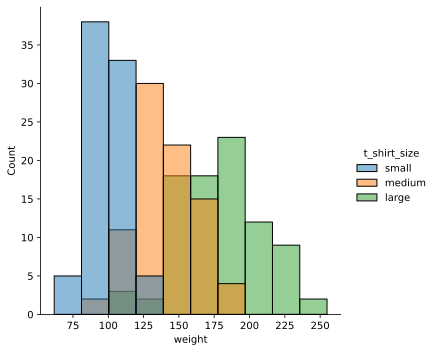

In [55]:
sns.displot(data=df, x="weight",  hue="t_shirt_size", kind='hist', fill=True);

#### kind ='kde', kde is a kernel density estimater, essentially calculates a gaussian distribution around each point, and then adds these distributions, and then divides by the number of points to get the smooth curves you see that have an area of 1.  I'm showing it because its easier to see the distributions

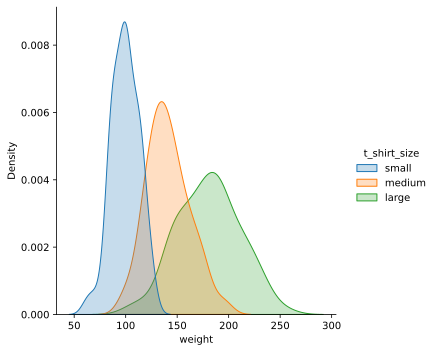

In [56]:
sns.displot(data=df, x="weight",  hue="t_shirt_size", kind='kde', fill=True);

## What to do about duplicates?  Delete them!

### Find them first

In [57]:
df.duplicated(keep=False).sum()

18

### Visually Verify 

In [58]:
df[df.duplicated(keep=False)].sort_values(by='name')

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
309,141.573538,medium,blue,Dennis Lopez,medium
104,141.573538,medium,blue,Dennis Lopez,medium
202,187.097422,large,red,Edna Turk,large
302,187.097422,large,red,Edna Turk,large
308,130.652350,medium,orange,Ericka Rodriguez,medium
103,130.652350,medium,orange,Ericka Rodriguez,medium
200,158.233361,large,red,Jan Tang,large
300,158.233361,large,red,Jan Tang,large
204,149.789781,large,red,Kris Angelo,large
304,149.789781,large,red,Kris Angelo,large


### Looks good lets dump them

In [59]:
df.drop_duplicates(inplace=True)

## What if one of the duplicated rows is missing the t-shirt size?  Then duplicated() will not find it.  Maybe we should check for duplicates in the 'name' column instead

In [60]:
df.name.duplicated(keep=False).sum()

12

### Verify that they are duplicates first

In [61]:
df[df.name.duplicated(keep=False)].sort_values(by='name')

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
4,87.290755,small,blue,David Huntsinger,small
314,87.290755,NaN,blue,David Huntsinger,small
1,119.165059,small,green,Douglas Nutt,small
311,119.165059,NaN,green,Douglas Nutt,small
102,138.196786,medium,blue,Mary Bowie,medium
307,138.196786,NaN,blue,Mary Bowie,medium
201,160.472101,large,orange,Timothy Miller,large
301,160.472101,NaN,orange,Timothy Miller,large
2,91.200858,NaN,green,Todd Stuer,small
312,91.200858,small,green,Todd Stuer,small


### We want to delete the one that has a np.nan for t_shirt_size.

In [62]:
df.drop( df[df.name.duplicated(keep=False) & (df.t_shirt_size.isna())].index, inplace=True)

## Duplicates are gone, now how to impute the missing fields

### One way is to use SimpleImputer and assign the median value to all the missing values


In [63]:
df_med=df.copy()

In [65]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  #works with strings
imp = imp.fit(df_med[['t_shirt_size']])   #here is where it determines what the most frequent is
df_med['impute_t_shirt_size']=imp.transform(df_med[['t_shirt_size']])  #here is where the transform is applied to create a new column 

In [66]:
# how many match
def printstats(df):
    tmp = df[(df['t_shirt_size'].isna())]
    numb=len(tmp)
    numbmatches=(tmp['t_shirt_size_orig']==tmp['impute_t_shirt_size']).sum()
    print(f'Correctly imputed {numbmatches} out of {numb} missing values')
printstats(df_med)

Correctly imputed 16 out of 57 missing values


In [37]:
#show calculated verses actual
# df_med[df_med['t_shirt_size'].isna()]

### Another way is to find the mean weight for each t-shirt size, and then assign missing value t-shirt size based on weight<br>
For each NaN assign t-shirt size to closest mean

#### First calculate average weight for each t-shirt size

In [95]:
df_better=df.copy()

In [96]:
avgs = df_better.groupby('t_shirt_size').mean()
avgs.weight

t_shirt_size
large     181.283631
medium    141.329739
small      99.930040
Name: weight, dtype: float64

In [97]:
#how many in each group
df_better.groupby('t_shirt_size').count()

,weight,t_shirt_color,name,t_shirt_size_orig
t_shirt_size,,,,
large,84,84,84,84
medium,80,80,80,80
small,79,79,79,79


#### Impute the value, replace the NaN

In [41]:
#map works on a column apply works on a row, which means we have access tothe entire row

def func(row):
    if row.t_shirt_size is np.NaN:
        #get a list of differences between this weight and average weights
        lst_vals = [abs(row.weight-val) for val in avgs.weight]

        #get the index of the minimum value
        min_val = min(lst_vals)
        min_index=lst_vals.index(min_val)

        #return t_shirt_size corresponding to this index
        return avgs.index[min_index]
    #its not missing, return what's there
    return row.t_shirt_size
df_better['impute_t_shirt_size'] = df.apply(func, axis=1)

#### Impute the value, replace the NaN, and add a 1 in a column to indicate that this value was imputed 
<mark>Prefered as this helps a ML algorithm because it shows which values are imputed

In [98]:
#map works on a column apply works on a row, which means we have access tothe entire row
#can also return more than 1 value so that we can have an indicator value

def func(row):
    if row.t_shirt_size is np.NaN:
        #get a list of differences between this weight and average weights
        lst_vals = [abs(row.weight-val) for val in avgs.weight]

        #get the index of the minimum value
        min_val = min(lst_vals)
        min_index=lst_vals.index(min_val)

        #return t_shirt_size corresponding to this index
        return pd.Series([avgs.index[min_index],1],index=['t_shirt_size','t_shirt_size_indicator'])
    #its not missing, return what's there
    return pd.Series([row.t_shirt_size,0],index=['t_shirt_size','t_shirt_size_indicator'])
df_better['t_shirt_size_indicator']=0
df_better[['t_shirt_size','t_shirt_size_indicator']]=df_better.apply(func, axis=1)

In [99]:
df_better[df_better['t_shirt_size_indicator']==1]

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig,t_shirt_size_indicator
8,95.177905,small,orange,Harley Tallant,small,1
11,106.883332,small,green,Ruth Mullins,small,1
16,95.421043,small,green,Ryan Chavis,small,1
27,84.383514,small,green,Ruby Hendrickson,small,1
32,67.568511,small,blue,Melvin Simar,small,1
36,107.180627,small,blue,Thomas Wilson,small,1
37,92.980998,small,orange,Jeffrey Freeman,small,1
40,102.097965,small,red,Cecil Tucker,small,1
43,146.212737,medium,blue,Carol Damour,small,1
44,124.382914,medium,green,Melissa Guzman,small,1


In [100]:
printstats(df_better)

KeyError: 'impute_t_shirt_size'

In [43]:
#show calculated verses actual
# df_better[df_better['t_shirt_size'].isna()]

# Generate Slide for the lecture

In [82]:
def func(df, numb=5):
    return (df.iloc[0:numb,:])
    
df.groupby('t_shirt_size', dropna=False).apply(func,numb=3)

weight t_shirt_size t_shirt_color               name  \
t_shirt_size                                                                 
large        200  175.806332        large         black      Wilda Englert   
             201  171.565476        large           red        Daryl Brown   
             202  171.112118        large         green   Danielle Edmonds   
med          100  139.421949          med           red        Royce Myers   
             101  153.059410          med          blue        James Bogan   
             102  156.298322          med        orange     Henry Mcintosh   
small        0    105.609500        small         black         George May   
             1    109.797011        small         black  Samuel Montgomery   
             2     95.883111        small        orange        Paula Moore   
NaN          3    104.410387          NaN           red       Steven Lopez   
             5     97.890768          NaN         green      Barbara Flynn   
             9     95.713558          NaN         black     Kathleen Reese   

                 t_shirt_size_orig  
t_shirt_size                        
large        200             large  
             201             large  
             202             large  
med          100               med  
             101               med  
             102               med  
small        0               small  
             1               small  
             2               small  
NaN          3               small  
             5               small  
             9               small